# -------------------------
# Imports
# -------------------------

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from tensorflow.keras import layers, Model

# -------------------------
# Load Dataset
# -------------------------

In [2]:
data = pd.read_excel("C:/Users/srian/Documents/GitHub/Generative-AI-project/Centrifugal_pumps_measurements.xlsx")

data

,Machine_ID,value_ISO,value_DEMO,value_ACC,value_P2P,valueTEMP,minute,second,year,month,day,hour,Pump_Status
0,1,0.349609,0.000343,0.012512,0.042480,24.25,33,41,2022,12,7,12,Healthy
1,1,0.349609,0.000343,0.012512,0.042480,24.25,33,46,2022,12,7,12,Healthy
2,1,0.349609,0.000343,0.012512,0.042480,24.25,33,51,2022,12,7,12,Healthy
3,1,0.349609,0.000343,0.012512,0.042480,24.25,33,56,2022,12,7,12,Healthy
4,1,0.349609,0.000343,0.012512,0.042480,24.25,34,1,2022,12,7,12,Healthy
...,...,...,...,...,...,...,...,...,...,...,...,...,...
5109,2,0.023193,0.000277,0.000637,0.006409,23.00,11,47,2022,12,14,15,Not Healthy
5110,2,0.023193,0.000277,0.000637,0.006409,23.00,11,52,2022,12,14,15,Not Healthy
5111,2,0.023193,0.000277,0.000637,0.006409,23.00,11,57,2022,12,14,15,Not Healthy
5112,2,0.023193,0.000277,0.000637,0.006409,23.00,12,2,2022,12,14,15,Not Healthy


# -------------------------
# Preprocessing
# -------------------------

In [3]:
data['datetime'] = pd.to_datetime(data[['year', 'month', 'day', 'hour', 'minute', 'second']])
data.set_index('datetime', inplace=True)
data.drop(['year', 'month', 'day', 'hour', 'minute', 'second'], axis=1, inplace=True)
data['Pump_Status'] = data['Pump_Status'].apply(lambda x: 1 if x == 'Healthy' else 0)

# -------------------------
# Create lag features
# -------------------------

In [4]:
for col in ['value_ISO', 'value_DEMO', 'value_ACC', 'value_P2P', 'valueTEMP']:
    data[f'{col}_lag1'] = data[col].shift(1)
    data[f'{col}_lag2'] = data[col].shift(2)

# Drop NaNs caused by lag features
data.dropna(inplace=True)

# -------------------------
# Scale Features
# -------------------------

In [5]:
features = data.drop('Pump_Status', axis=1)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(features)

# -------------------------
# VAE Model Components
# -------------------------

In [6]:
input_dim = X_scaled.shape[1]
latent_dim = 2

class Sampling(layers.Layer):
    def call(self, inputs):
        z_mean, z_log_var = inputs
        epsilon = tf.random.normal(shape=tf.shape(z_mean))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

# Encoder
encoder_inputs = layers.Input(shape=(input_dim,))
x = layers.Dense(64, activation='relu')(encoder_inputs)
x = layers.Dense(32, activation='relu')(x)
z_mean = layers.Dense(latent_dim, name='z_mean')(x)
z_log_var = layers.Dense(latent_dim, name='z_log_var')(x)
z = Sampling()([z_mean, z_log_var])
encoder = Model(encoder_inputs, [z_mean, z_log_var, z], name="encoder")

# Decoder
decoder_inputs = layers.Input(shape=(latent_dim,))
x = layers.Dense(32, activation='relu')(decoder_inputs)
x = layers.Dense(64, activation='relu')(x)
decoder_outputs = layers.Dense(input_dim, activation='linear')(x)
decoder = Model(decoder_inputs, decoder_outputs, name="decoder")

# VAE Model
class VAE(Model):
    def __init__(self, encoder, decoder, **kwargs):
        super(VAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.total_loss_tracker = tf.keras.metrics.Mean(name="loss")
        self.reconstruction_loss_tracker = tf.keras.metrics.Mean(name="reconstruction_loss")
        self.kl_loss_tracker = tf.keras.metrics.Mean(name="kl_loss")

    def train_step(self, data):
        if isinstance(data, tuple):
            data = data[0]
        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = self.encoder(data)
            reconstruction = self.decoder(z)
            reconstruction_loss = tf.reduce_mean(tf.reduce_sum(tf.square(data - reconstruction), axis=1))
            kl_loss = -0.5 * tf.reduce_mean(tf.reduce_sum(1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var), axis=1))
            total_loss = reconstruction_loss + kl_loss
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
        }

    def call(self, inputs):
        z_mean, z_log_var, z = self.encoder(inputs)
        return self.decoder(z)

# -------------------------
# Compile and Train
# -------------------------

Epoch 1/100
160/160 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - kl_loss: 1.2152 - loss: 12.8110 - reconstruction_loss: 11.5958
Epoch 2/100
160/160 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - kl_loss: 1.9451 - loss: 5.2998 - reconstruction_loss: 3.3546
Epoch 3/100
160/160 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - kl_loss: 1.7972 - loss: 4.6532 - reconstruction_loss: 2.8559
Epoch 4/100
160/160 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - kl_loss: 1.8191 - loss: 4.7406 - reconstruction_loss: 2.9215
Epoch 5/100
160/160 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - kl_loss: 1.8760 - loss: 4.5025 - reconstruction_loss: 2.6265
Epoch 6/100
160/160 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - kl_loss: 1.9196 - loss: 4.3215 - reconstruction_loss: 2.4019
Epoch 7/100
160/160 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - kl_loss: 1.9743 - loss: 4.1109 - reconstruction_loss: 2.1366
Epoch 8/100
160/160 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - kl_loss: 1.9519 - loss: 4.0458 - reconstruction_loss: 2.0940
Epoch 9/100
160/160 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - kl_loss: 1.8540

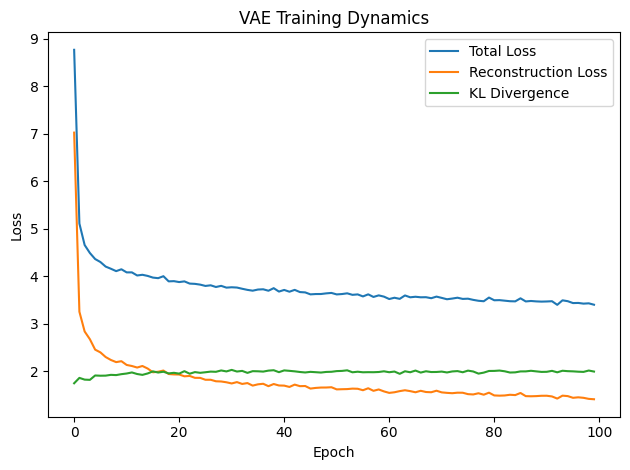

In [7]:
vae = VAE(encoder, decoder)
vae.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001))

history = vae.fit(X_scaled, epochs=100, batch_size=32, verbose=1)

# Plot Training Losses
plt.plot(history.history['loss'], label='Total Loss')
plt.plot(history.history['reconstruction_loss'], label='Reconstruction Loss')
plt.plot(history.history['kl_loss'], label='KL Divergence')
plt.title("VAE Training Dynamics")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.tight_layout()
plt.show()

# -------------------------
# Compute Reconstruction Errors (Anomaly Scores)
# -------------------------

In [9]:
reconstructed = vae.predict(X_scaled)
reconstruction_errors = np.mean(np.square(X_scaled - reconstructed), axis=1)

# Add anomaly score to dataframe
data['anomaly_score'] = reconstruction_errors

# Set threshold (e.g., 95th percentile of reconstruction error)
threshold = np.percentile(reconstruction_errors, 95)
data['anomaly'] = data['anomaly_score'] > threshold

160/160 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


# -------------------------
# Plot 1: Anomaly Score Over Time
# -------------------------

##### If all values are near zero (e.g., <1e-6), your VAE might have overfit or learned to reconstruct everything too perfectly.

In [10]:
print("Reconstruction Error - min:", reconstruction_errors.min())
print("Reconstruction Error - max:", reconstruction_errors.max())
print("Reconstruction Error - mean:", reconstruction_errors.mean())

Reconstruction Error - min: 0.0002431946801707858
Reconstruction Error - max: 4.621233808546739
Reconstruction Error - mean: 0.08948744853599595


In [11]:
# print("X_scaled shape:", X_scaled.shape)
# print("X_scaled sample values:", X_scaled[:5])

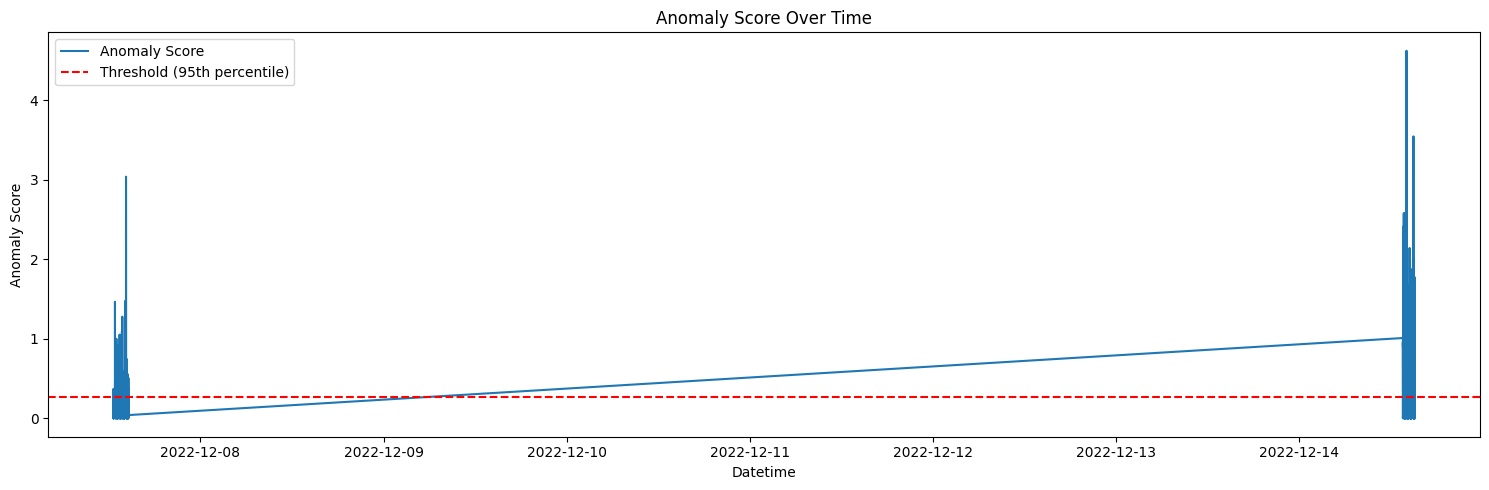

In [12]:
plt.figure(figsize=(15, 5))
plt.plot(data.index, data['anomaly_score'], label='Anomaly Score')
plt.axhline(y=threshold, color='r', linestyle='--', label='Threshold (95th percentile)')
plt.title('Anomaly Score Over Time')
plt.xlabel('Datetime')
plt.ylabel('Anomaly Score')
plt.legend()
plt.tight_layout()
plt.show()

# -------------------------
# Plot 2: Actual vs Predicted Pump Status
# -------------------------

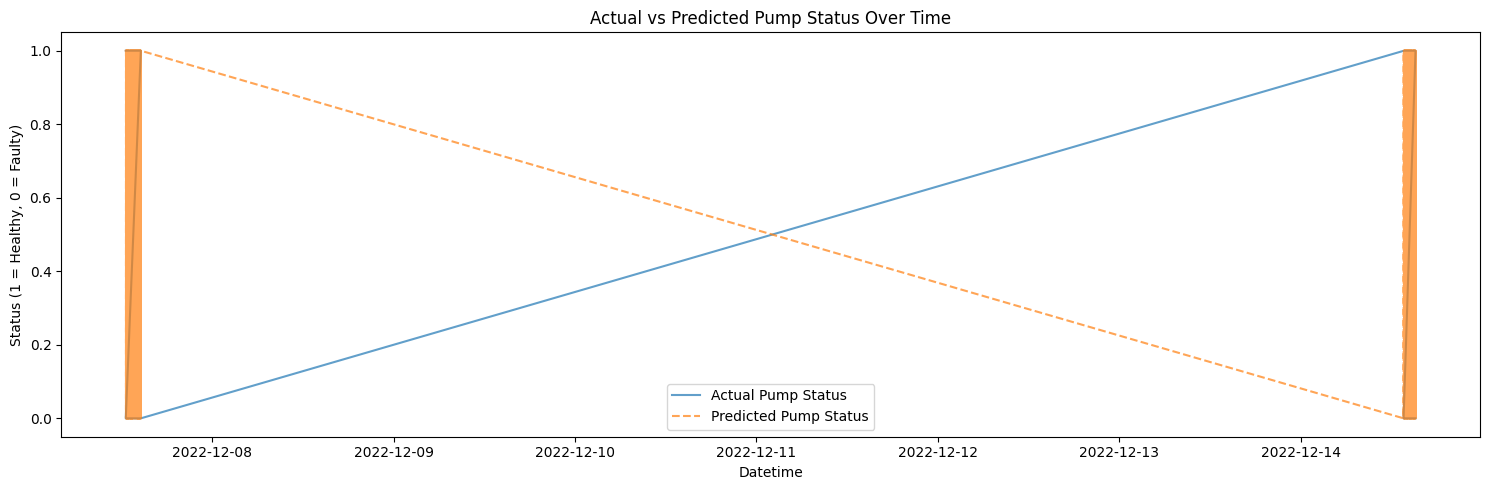

In [13]:
data['predicted_status'] = data['anomaly'].apply(lambda x: 0 if x else 1)

plt.figure(figsize=(15, 5))
plt.plot(data.index, data['Pump_Status'], label='Actual Pump Status', alpha=0.7)
plt.plot(data.index, data['predicted_status'], label='Predicted Pump Status', linestyle='--', alpha=0.7)
plt.title('Actual vs Predicted Pump Status Over Time')
plt.xlabel('Datetime')
plt.ylabel('Status (1 = Healthy, 0 = Faulty)')
plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
# import seaborn as sns
# sns.histplot(reconstruction_errors, kde=True)
# plt.axvline(threshold, color='red', linestyle='--')
# plt.title("Reconstruction Error Distribution")

In [ ]:
# print("95th percentile threshold:", threshold)
# print("Reconstruction error sample:", reconstruction_errors[:10])

In [ ]:
# plt.figure(figsize=(15, 4))
# plt.plot(data.index[-len(reconstruction_errors):], reconstruction_errors, label='Anomaly Score')
# plt.axhline(threshold, color='red', linestyle='--', label='Threshold (95th percentile)')
# plt.title('Anomaly Score Over Time')
# plt.legend()
# plt.show()

In [ ]:
# print(np.isnan(X_scaled).sum())

In [ ]:
print("Any NaNs in X_scaled?", np.isnan(X_scaled).sum())
print("Any NaNs in reconstruction?", np.isnan(reconstructed).sum())
print("Threshold:", threshold)
print("Reconstruction Errors (first 5):", reconstruction_errors[:5])